In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable
import torch.optim as optim
from torch import autograd

import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

In [0]:
torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [3]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 100
task_number = 50
mnist_size = (28, 28)

random_seed = 1
torch.manual_seed(random_seed)

In [0]:
root = './data'
if not os.path.exists(root):
    os.mkdir(root)

In [0]:
def get_dataset(permutation, get_train=True):
    trans_perm = torchvision.transforms.Compose([transforms.ToTensor(),
              torchvision.transforms.Lambda(lambda x: x.view(-1)[permutation].view(1, 28, 28))])
    
    dataset = datasets.MNIST(root=root, train=get_train, transform=trans_perm, download=True)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size_train, shuffle=True)
    return loader

In [0]:
np.random.seed(random_seed)
permutations = [
    np.random.permutation(28 * 28) for
    _ in range(task_number)
]

train_datasets = [
    get_dataset(p) for p in permutations
]
test_datasets = [
    get_dataset(p, get_train=False) for p in permutations
]

In [0]:
class LinearModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super(LinearModel, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.layer1 = nn.Linear(self.input_size, self.hidden_size)
        self.act1 = nn.ReLU()
        
        self.layer2 = nn.Linear(self.hidden_size, self.hidden_size)
        self.act2 = nn.ReLU()
        
        self.layer3 = nn.Linear(self.hidden_size, self.output_size)
        self.log_probs = nn.LogSoftmax(dim=-1)
    
    def forward(self, x):
        x = x.view(-1, self.input_size)
        
        x = self.layer1(x)
        x = self.act1(x)
        
        x = self.layer2(x)
        x = self.act2(x)
        
        x = self.layer3(x)
        return self.log_probs(x)

In [0]:
def train(model, train_loader, optimizer, epoch, log=False):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if log and batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, test_datasets):
    model.eval()
    test_loss = 0
    correct = 0
    all_data_size = 0
    
    with torch.no_grad():
        for test_loader in test_datasets:
            for data, target in test_loader:
                output = model(data)
                pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
                correct += pred.eq(target.view_as(pred)).sum().item()
                all_data_size += len(data)
    print(100. * correct / all_data_size)
    return (100. * correct / all_data_size)

In [0]:
model = LinearModel(28 * 28, 10, 100)
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                      momentum=momentum)

test_acc_linear = []

In [0]:
for task_no, train_loader in enumerate(train_datasets, 1):
    for epoch in range(1, n_epochs + 1):
        train(model, train_loader, optimizer, epoch, log=True)
        test_acc_linear.append(
            test(model, test_datasets[:task_no])
        )

## EWC

In [0]:
class EWCModel(nn.Module):
    def __init__(self, input_size, output_size,
                 hidden_size=100):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.layers = nn.ModuleList([
            nn.Linear(self.input_size, self.hidden_size), nn.ReLU(),
            nn.Linear(self.hidden_size, self.hidden_size), nn.ReLU(),
            nn.Linear(self.hidden_size, self.output_size)
        ])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def estimate_fisher(self, data_loader):
        loglikelihoods = []
        # iterate through each batch
        for x, y in data_loader:
            x = x.view(len(x), -1)
            loglikelihoods.append(
                F.log_softmax(self(x), dim=0)[range(len(x)), y.data]
            )

        # estimate the fisher information of the parameters.
        loglikelihood = torch.cat(loglikelihoods).mean(dim=0)
        # grad by parametrs
        loglikelihood_grads = autograd.grad(loglikelihood, self.parameters())
        parameter_names = [
            n.replace('.', '__') for n, p in self.named_parameters()
        ]
        return {n: g ** 2 for n, g in zip(parameter_names, loglikelihood_grads)}

    def consolidate(self, fisher):
        for n, p in self.named_parameters():
            n = n.replace('.', '__')
            self.register_buffer('{}_estimated_opt'.format(n), p.data.clone())
            self.register_buffer('{}_estimated_fisher'
                                 .format(n), fisher[n].data.clone())

    def ewc_loss(self, lamda, cuda=False):
        try:
            losses = []
            for param_name, param_val in self.named_parameters():
                # retrieve the consolidated mean and fisher information.
                param_name = param_name.replace('.', '__')
                prev_opt = getattr(self, '{}_estimated_opt'.format(param_name))
                fisher = getattr(self, '{}_estimated_fisher'.format(param_name))
                losses.append((fisher * (param_val - prev_opt) ** 2).sum())
            return (lamda / 2) * sum(losses)
        except AttributeError:
            # ewc loss is 0 if there's no consolidated parameters.
            return (
                Variable(torch.zeros(1))
            )

In [0]:
def trainEWC(model, train_loader, optimizer, epoch, log=False):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        
        output = model(data.view(len(data), -1))
        criteriton = nn.CrossEntropyLoss()
        ce_loss = criteriton(output, target)
        ewc_loss = model.ewc_loss(lamda)
        loss = ce_loss + ewc_loss
        
        loss.backward()
        optimizer.step()
        
        if log and batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


def test(model, test_datasets):
    model.eval()
    test_loss = 0
    correct = 0
    all_data_size = 0
    
    with torch.no_grad():
        for test_loader in test_datasets:
            for data, target in test_loader:
                output = model(data.view(len(data), -1))
                pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
                correct += pred.eq(target.view_as(pred)).sum().item()
                all_data_size += len(data)
    print(100. * correct / all_data_size)
    return (100. * correct / all_data_size)

In [0]:
model_ewc = EWCModel(28 * 28, 10)
optimizer = optim.SGD(model_ewc.parameters(), lr=learning_rate,
                      momentum=momentum)

test_acc_ewc = []
lamda = 3
n_epochs = 

In [0]:
for task_no, train_loader in enumerate(train_datasets, 1):
    for epoch in range(1, n_epochs + 1):
        trainEWC(model_ewc, train_loader, optimizer, epoch, log=True)
        test_acc_ewc.append(
            test(model_ewc, test_datasets[:task_no])
        )
    # update Fisher matrix
    model_ewc.consolidate(
        model_ewc.estimate_fisher(train_loader)
                         )


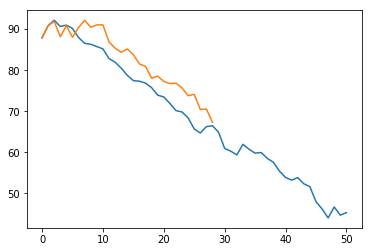

In [0]:
s = 51
plt.plot(test_acc_linear[:s])
plt.plot(test_acc_linear[s:])

### K-FA

In [0]:
torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [0]:
class KFAModel(nn.Module):
    def __init__(self, input_size, output_size,
                 hidden_size=100):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        
        
        self.layers = nn.ModuleList([
            nn.Linear(self.input_size, self.hidden_size, bias=False), nn.ReLU(),
            nn.Linear(self.hidden_size, self.hidden_size, bias=False), nn.ReLU(),
            nn.Linear(self.hidden_size, self.output_size, bias=False)
        ])
        
        self.store_factors = False
        self.WB_factors = None
        
        
        # factors init
        self.Q_factors = []
        self.H_factors = []
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                self.Q_factors.append(torch.zeros(layer.in_features, layer.in_features))
                self.H_factors.append(torch.zeros(layer.out_features, layer.out_features))
        # optimal weights init with random
        self.prev_W = []
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                self.prev_W.append(layer.weight.data.clone())

    def forward(self, inputs):
        curr_linear_layer = 0
        for layer_ind, layer in enumerate(self.layers):
            # add bias before linear layer
            #BIAS
#             if isinstance(layer, nn.Linear):
#                 inputs = torch.cat([inputs, torch.ones(inputs.size(0), 1)],dim=1)
            output = layer(inputs)
            
            if self.store_factors:
                if isinstance(layer, nn.Linear):
                    
                    self.Q_factors[curr_linear_layer] += torch.bmm(inputs.unsqueeze(2).data.clone(),
                                                                   inputs.unsqueeze(1).data.clone()).sum(dim=0)
                    self.WB_factors[curr_linear_layer] = torch.mm(self.WB_factors[curr_linear_layer],
                                                                  layer.weight.transpose(dim0=1, dim1=0).data.clone())
                    curr_linear_layer += 1
                elif isinstance(layer, nn.ReLU):
                    df_dh = autograd.grad(output, inputs, grad_outputs=torch.ones_like(inputs))[0]
#                     BIAS
#                     self.WB_factors[curr_linear_layer][:-1, :-1] = torch.diag(df_dh[0])
                    self.WB_factors[curr_linear_layer] = torch.diag(df_dh[0].data.clone())
                
            inputs = output
        return output
    


In [0]:
# loss
def calc_kfa_loss():
    loss = 0
    ind = 0
    for layer in kfa_model.layers:
        if isinstance(layer, nn.Linear):
            kfa_model.H_factors[ind].detach_()
            kfa_model.Q_factors[ind].detach_()
#             loss += 0.5 * torch.sum((layer.weight - kfa_model.prev_W[ind]).transpose(dim0=1, dim1=0) @ \
#                     kfa_model.H_factors[ind] @ \
#                     (layer.weight - kfa_model.prev_W[ind]) @ \
#                     kfa_model.Q_factors[ind])
            loss += 0.5 * (layer.weight - kfa_model.prev_W[ind]).view(1, -1) @ \
                            (kfa_model.H_factors[ind] @ \
                            (layer.weight - kfa_model.prev_W[ind]) @ \
                            kfa_model.Q_factors[ind]).view(-1, 1)
            ind += 1
    return loss

In [0]:
def test(model, test_datasets):
    model.eval()
    test_loss = 0
    correct = 0
    all_data_size = 0
    
    with torch.no_grad():
        for test_loader in test_datasets:
            for data, target in test_loader:
                output = model(data.view(len(data), -1).cuda())
                pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
                correct += pred.eq(target.view_as(pred).cuda()).sum().item()
                all_data_size += len(data)
    print(100. * correct / all_data_size)
    return (100. * correct / all_data_size)

In [0]:
kfa_model = KFAModel(28 * 28, 10)
kfa_model.cuda()

optimizer = optim.SGD(kfa_model.parameters(), lr=learning_rate,
                      momentum=momentum)
log = True
test_acc = []

In [0]:
for n_datasets, train_loader in enumerate(train_datasets[:10], 1):
    kfa_model.train()
    # standart training
    for epoch in range(5):
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()

            output = kfa_model(data.view(len(data), -1).cuda())
            criteriton = nn.CrossEntropyLoss()
            ce_loss = criteriton(output, target.cuda())
            kfa_loss = calc_kfa_loss()
            loss = ce_loss + 3 * kfa_loss
#             loss = ce_loss

            loss.backward()
            optimizer.step()

            if log and batch_idx % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), kfa_loss.item()))
    
        test_acc.append(test(kfa_model, test_datasets[:n_datasets]))
    
#     update cycle
    n_data = 0
    kfa_model.store_factors = True
    prev_H = [] #kfa_model.H_factors.clone()
    prev_Q = [] #kfa_model.Q_factors.clone()
    for ind in range(len(kfa_model.H_factors)):
        prev_H.append(kfa_model.H_factors[ind].data.clone().detach())
        prev_Q.append(kfa_model.Q_factors[ind].data.clone().detach())
    
    for data, target in tqdm(train_loader):
#         print(prev_Q)
        kfa_model.WB_factors = []
        for layer in kfa_model.layers:
            if isinstance(layer, nn.Linear):
                kfa_model.WB_factors.append(torch.zeros(layer.in_features, layer.in_features))

        data = data.view(-1, 28 * 28).cuda()
        output = kfa_model(data)

        # backward
        E = F.cross_entropy(output, target.cuda())
        dE_dh = autograd.grad(E, output, create_graph=True)[0]
        H_L = torch.stack([autograd.grad(dE_dhi, output, retain_graph=True)[0][0] for dE_dhi in dE_dh[0]])
    #     print(H_L.shape)
        # in reversed order
        H_factors = [H_L]

        for ind, BW_t in enumerate(reversed(kfa_model.WB_factors[1:])):
            H_next = H_factors[-1]
    #         print(BW_t.shape, H_next.shape)
            H_factors.append(BW_t @ H_next @ torch.transpose(BW_t, dim1=0, dim0=1))
#             if torch.all(torch.eig(kfa_model.H_factors[-1])[0][:, 0] > 0) == 0:
#                 print(BW_t)
#                 break
        for l, Hl in enumerate(reversed(H_factors)):
            kfa_model.H_factors[l] += Hl

        n_data += len(data)
#         break

    for ind in range(len(kfa_model.Q_factors)):
        kfa_model.Q_factors[ind] /= n_data
        kfa_model.Q_factors[ind] += prev_Q[ind]
        kfa_model.H_factors[ind] /= n_data
        kfa_model.H_factors[ind] += prev_H[ind]

    kfa_model.prev_W = []
    for layer in kfa_model.layers:
        if isinstance(layer, nn.Linear):
            kfa_model.prev_W.append(layer.weight.data.clone())
    # end of Q, H update. Don't change during other cycle
    kfa_model.store_factors = False
    


    
    

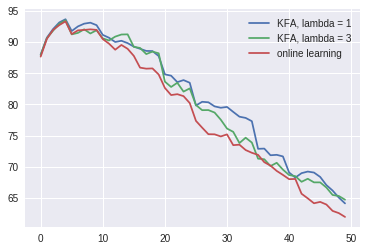

In [53]:
plt.plot(test_acc_wl, label="KFA, lambda = 1")
plt.plot(test_acc_5, label="KFA, lambda = 3")
plt.plot(test_acc_without_loss, label="online learning")
plt.legend()